In [0]:
%tensorflow_version 2  # This tells Colab to use TF2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2  # This tells Colab to use TF2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


# Active Wave Breaking Classifier

This program loads manually labbelled wave image data and classify the images into "breaking" (1) or "no-breaking" (0).

The data needs to be in a folder called "data256px" which has sub-folders "0" and "1"

For example:
```
└───data256px
    ├───0
    ├───1
```

There are 3 "backbones" implemented: "VGG16", "ResNet50V2", and "InceptionResNetV2"

Note that the weights from these pre-trained models will be reset and updated from the scracth here. These models have no knowledge of the present data and, consequently, transfered learning does not work well.

```
# PROGRAM   : wave_breaking_classifier.py
# POURPOSE  : classify wave breaking using a convnets
# AUTHOR    : Caio Eadi Stringari
# EMAIL     : caio.stringari@gmail.com
# V1.0      : 18/03/2019 [Caio Stringari]
```

## Data Download

Load data from my google drive. You may need to copy the data over to yours to use this program.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!cp "/content/drive/My Drive/Colab Notebooks/FEM/data256px.tar" .
!tar -xvf data256px.tar

## Imports

In [0]:
import os

import numpy as np

import datetime

import pandas as pd

import pathlib

import platform

from tensorflow import summary
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16, ResNet50V2, InceptionResNetV2
from tensorflow.keras.layers import (Dense, Dropout, Flatten)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

## Constants and Hyper-parameters

In [0]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.00001
EPOCHS = 128
BATCH_SIZE = 32
DROPOUT = 0.5
IMGSIZE = (128, 128)  # this is the target size, not the original size
logdir="logs"
DATA="data256px"
backbone="ResNet50V2"
basename="ResNetBaseline"

In [0]:
METRICS = [metrics.TruePositives(name="True_Positives"),
           metrics.FalsePositives(name="False_Positives"),
           metrics.TrueNegatives(name="True_Negatives"),
           metrics.FalseNegatives(name="False_Negatives"),
           metrics.BinaryAccuracy(name="Binary_Accuracy"),
           metrics.Precision(name="Precision"),
           metrics.Recall(name="Recall"),
           metrics.AUC(name="AUC")]

## Tensorbord Callbacks

After the model is trained, you can copy this logs to a local machine and visualize them. At the moment, I do nto know how to integrate tensorboard and Colab.

In [0]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if platform.system().lower() == "windows":
    logdir = logdir + "\\" + date
else:
    logdir = logdir + "/" + date
if not os.path.isdir(logdir):
    os.makedirs(logdir, exist_ok=True)

In [0]:
tensorboard = callbacks.TensorBoard(log_dir=logdir,
                                    histogram_freq=1,
                                    profile_batch=1)

## Data Augumentation

Because the dataset has relatively few samples (10k), we need some data augumentation so that our model trains better.

The augumentations steps are:
1. Rescale in the range [0, 1]
2. Rotate the data in 20 degrees angles
3. Shift the data in the horizontal and vertical orientations
4. Flip up-down and left-right
5. Zoom in and out by 20%

Keras generators will take care of all this  for us.

In [0]:
# --- data input ---
data_dir = DATA
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))

class_names = np.array([item.name for item in data_dir.glob('*')])

try:
    nclasses = len(class_names)
    print("  Found image data, proceeding.\n")
    print("   - Classes are {}".format(class_names))
except Exception:
    raise IOError("Check your data!")

img_height = IMGSIZE[0]  # image height for all images
img_width = IMGSIZE[1]  # image width for all images

  Found image data, proceeding.

   - Classes are ['0' '1']


In [0]:
# tells the Generator when to stop
steps_per_epoch = np.ceil(image_count / BATCH_SIZE)

datagen = ImageDataGenerator(zoom_range=0.2,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rescale=1./255.,
                             validation_split=TEST_SIZE)

print("\n    Fitting the training data generator:\n")
data_gen_train = datagen.flow_from_directory(
    directory=str(data_dir), batch_size=BATCH_SIZE, shuffle=True,
    target_size=(img_height, img_width), classes=list(class_names),
    subset='training', class_mode="binary")

print("\n    Fitting the validation data generator:\n")
data_gen_valid = datagen.flow_from_directory(
    directory=str(data_dir), batch_size=BATCH_SIZE, shuffle=True,
    target_size=(img_height, img_width), classes=list(class_names),
    subset='validation', class_mode="binary")


    Fitting the training data generator:

Found 7220 images belonging to 2 classes.

    Fitting the validation data generator:

Found 1804 images belonging to 2 classes.


In [0]:
def show_batch(image_batch, label_batch):
    fig = plt.figure(figsize=(10, 10))
    for n in range(32):
        ax = plt.subplot(6, 6, n + 1)
        plt.imshow(image_batch[n])
        plt.title("class : "+str(int(label_batch[n])))
        plt.axis('off')
    fig.tight_layout()

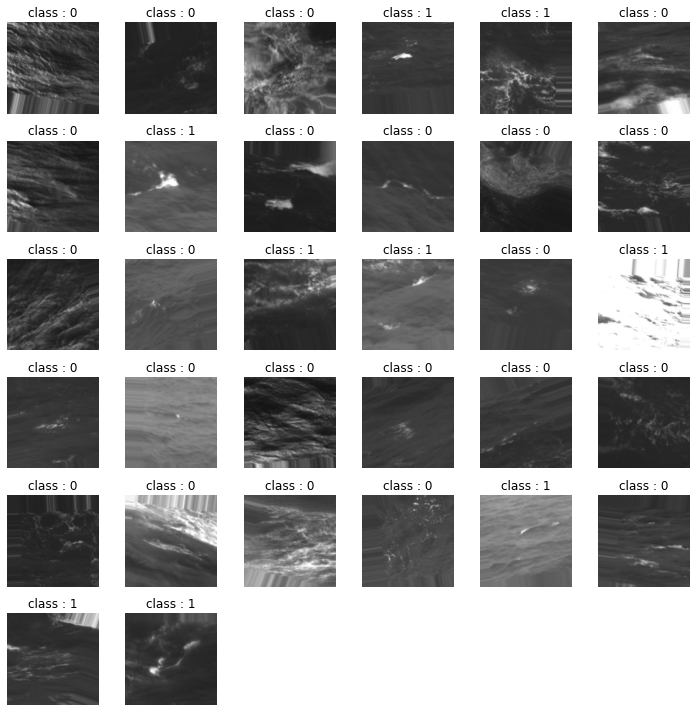

In [0]:
image_batch, label_batch = next(data_gen_train)
show_batch(image_batch, label_batch)

## Model Definition

Please use "VGG16", "ResNetV250", or "InceptionResNetV2". All other architetures must be adapted.

Note that I am using ```Flatten()``` instead of ```Global Average Pooling```. The model seems to learn better using ```Flatten```.

In [0]:
# --- model definition ---

print("\n - Training using {} as backbone".format(backbone))

# # define model input
if backbone.lower() == "VGG16".lower():
    base_model = VGG16(input_shape=(img_height, img_width, 3),
                       include_top=False,
                       weights=None)
elif backbone.lower() == "ResNet50V2".lower():
    base_model = ResNet50V2(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights=None)
elif backbone.lower() == "InceptionResNetV2".lower():
    base_model = InceptionResNetV2(input_shape=(img_height, img_width, 3),
                                   include_top=False,
                                   weights=None)
else:
    raise NotImplementedError("Unknown backbone \'{}\' ".format())
base_model.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048)(x)
x = Dropout(DROPOUT)(x)
x = Dense(1024)(x)
x = Dropout(DROPOUT)(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


 - Training using ResNet50V2 as backbone
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
____________________________________________________

In [0]:
# compile the model
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
loss = BinaryCrossentropy(from_logits=False)
model.compile(optimizer=optimizer,
              loss=loss,  # try categorical_hinge later
              metrics=METRICS)

## Training Loop

This will take about 3 hours on GPU.

In [0]:
# --- train ---
history = model.fit(data_gen_train,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=data_gen_valid,
                    callbacks=[tensorboard])
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

## Data Upload

Save the data to Google Drive.

In [0]:
model.save("{}.h5".format(os.path.join(logdir, basename)))
hist.to_csv("{}.cvs".format(os.path.join(logdir, basename)))


 - Saving model to file


In [0]:
!tar -zcvf logs.tar.gz logs/

In [0]:
!mv logs.tar.gz "/content/drive/My Drive/Colab Notebooks/FEM"